In [1]:
import numpy as np
import cartopy
from cartopy import crs
from cartopy.feature import NaturalEarthFeature
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import xarray as xr
import os

from wrf import (getvar, interplevel, vertcross, 
                 CoordPair, ALL_TIMES, to_np,
                 get_cartopy, latlon_coords,
                 cartopy_xlim, cartopy_ylim)

/home/lmar/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/lmar/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


The following code has been adapted from the WRF python tutorial presented by the National Centre for Atmospheric Research: https://github.com/NCAR/wrf_python_tutorial

### Importing WRF data

Here we access data from the forecast that was initialised at 1pm on the 14th May 2024, as can be infered from the directory name.

We choose the data valid at 13:00 on the first day of the forecast (2024-05-14) from domain 2.

The directory name - which implies the initialisation time - is a convention that we use to store and sort our data.

The filename - which implies the valid time - is the standard format for WRF output files.

Their generic format is:

`wrfout_d{domain number}_{YYYY}-{MM}-{DD}_{hh}:{mm}:{ss}`

We then create a `netCDF4` `Dataset` object of this wrfout.


In [16]:
WRF_DIRECTORY = "/data/shared_data/model/2024051412/" 
WRF_FILE = WRF_DIRECTORY + "wrfout_d02_2024-05-14_13:00:00"

wrfout = xr.open_dataset(WRF_FILE)

The `wrfout` variable represents a netCDF file, which we have extracted using `xarray`.

In a jupyter notebook `xarray` let's us take a look at our data nicely.

In [17]:
wrfout

<xarray.Dataset> Size: 351MB
Dimensions:                (Time: 1, south_north: 290, west_east: 240,
                            bottom_top: 50, bottom_top_stag: 51,
                            soil_layers_stag: 4, west_east_stag: 241,
                            south_north_stag: 291, seed_dim_stag: 8)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 278kB ...
    XLONG                  (Time, south_north, west_east) float32 278kB ...
    XTIME                  (Time) datetime64[ns] 8B ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 280kB ...
    XLONG_U                (Time, south_north, west_east_stag) float32 280kB ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 279kB ...
    XLONG_V                (Time, south_north_stag, west_east) float32 279kB ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag, seed_dim_stag
Data variables: (12/165)
    Times                  (Time) |S19 19B ...
    LU_INDEX               (Time, south_north, west_east) float32 278kB ...
    ZNU                    (Time, bottom_top) float32 200B ...
    ZNW                    (Time, bottom_top_stag) float32 204B ...
    ZS                     (Time, soil_layers_stag) float32 16B ...
    DZS                    (Time, soil_layers_stag) float32 16B ...
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 278kB ...
    PC                     (Time, south_north, west_east) float32 278kB ...
    LANDMASK               (Time, south_north, west_east) float32 278kB ...
    LAKEMASK               (Time, south_north, west_east) float32 278kB ...
    SST                    (Time, south_north, west_east) float32 278kB ...
    SST_INPUT              (Time, south_north, west_east) float32 278kB ...
Attributes: (12/134)
    TITLE:                            OUTPUT FROM WRF V4.4.2 MODEL
    START_DATE:                      2024-05-14_12:00:00
    SIMULATION_START_DATE:           2024-05-14_12:00:00
    WEST-EAST_GRID_DIMENSION:        241
    SOUTH-NORTH_GRID_DIMENSION:      291
    BOTTOM-TOP_GRID_DIMENSION:       51
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

We access data from the dataset as we would a python dictionary.

We can pull out something specific, such as 2m temperature.

Here we have use the variable name `'T2'` as our key: 

In [18]:
wrfout['T2']

<xarray.DataArray 'T2' (Time: 1, south_north: 290, west_east: 240)> Size: 278kB
[69600 values with dtype=float32]
Coordinates:
    XLAT     (Time, south_north, west_east) float32 278kB ...
    XLONG    (Time, south_north, west_east) float32 278kB ...
    XTIME    (Time) datetime64[ns] 8B ...
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:

We can access the data by using python list index notation:

In [19]:
wrfout['T2'][:,50,38]

<xarray.DataArray 'T2' (Time: 1)> Size: 4B
[1 values with dtype=float32]
Coordinates:
    XLAT     (Time) float32 4B ...
    XLONG    (Time) float32 4B ...
    XTIME    (Time) datetime64[ns] 8B ...
Dimensions without coordinates: Time
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:

### Extracting WRF variables using `getvar`

We will use the `wrf-python` function `getvar` to extract certain diagnostics from our wrfout files.

Some diagnostics come 'out of the box' in a wrfout, `getvar` extends this and also adds some nice functionality like concatenating the data from multiple wrfouts into a single file. 

The full list of diagnostics can be found here: https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.getvar.html.

`getvar` is only compatible with `Dataset` object from the `netCDF4` package (even though it returns an `xarray` `DataArray` object...!?), so we will re read it:

In [20]:
wrfout = Dataset(WRF_FILE)

We will extract sea level pressure, using the variable name string `'slp'`:

In [21]:
slp = getvar(wrfout, 'slp')

In [22]:
slp

<xarray.DataArray 'slp' (south_north: 290, west_east: 240)> Size: 278kB
array([[ 995.956  ,  995.85297,  995.74414, ..., 1004.31885, 1004.40424,
        1004.6075 ],
       [ 995.96796,  995.80286,  995.66223, ..., 1004.5239 , 1004.62286,
        1004.669  ],
       [ 995.99506,  995.79065,  995.6394 , ..., 1004.5466 , 1004.61255,
        1004.6626 ],
       ...,
       [1008.87164, 1008.8152 , 1008.78375, ..., 1013.1907 , 1013.2604 ,
        1013.3313 ],
       [1008.92847, 1008.8841 , 1008.8141 , ..., 1013.188  , 1013.27045,
        1013.3363 ],
       [1008.98206, 1008.9411 , 1008.90247, ..., 1013.1794 , 1013.2685 ,
        1013.3399 ]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 278kB -10.61 -10.55 ... 4.158
    XLAT     (south_north, west_east) float32 278kB 49.71 49.71 ... 60.35 60.35
    XTIME    float32 4B 60.0
    Time     datetime64[ns] 8B 2024-05-14T13:00:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY
    description:  sea level pressure
    units:        hPa
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-2.0, moad_cen_lat=57.0, truelat...

### Plotting with `cartopy`

`wrf-python` provides functions for retrieving spacial information from our `slp` object.

We will extract the projection and coordinates:

In [23]:
cart_proj = get_cartopy(slp)
lats, lons = latlon_coords(slp)

In [24]:
cart_proj

<Bound CRS: +proj=lcc +a=6370000.0 +b=6370000.0 +nadgrids=@nul ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown to WGS84
- method: NTv2
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich
Source CRS: unknown

In [25]:
lats

<xarray.DataArray 'XLAT' (south_north: 290, west_east: 240)> Size: 278kB
array([[49.707195, 49.71169 , 49.716156, ..., 49.95818 , 49.95575 ,
        49.953293],
       [49.74279 , 49.74729 , 49.751766, ..., 49.994   , 49.991573,
        49.98911 ],
       [49.778393, 49.782898, 49.787373, ..., 50.02982 , 50.02739 ,
        50.024937],
       ...,
       [59.957314, 59.963192, 59.96904 , ..., 60.286133, 60.282944,
        60.27972 ],
       [59.992943, 59.99883 , 60.004673, ..., 60.322083, 60.3189  ,
        60.315674],
       [60.028557, 60.034447, 60.040302, ..., 60.358044, 60.35485 ,
        60.35162 ]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 278kB -10.61 -10.55 ... 4.158
    XLAT     (south_north, west_east) float32 278kB 49.71 49.71 ... 60.35 60.35
    XTIME    float32 4B 60.0
    Time     datetime64[ns] 8B 2024-05-14T13:00:00
Dimensions without coordinates: south_north, west_east

In [26]:
lons

<xarray.DataArray 'XLONG' (south_north: 290, west_east: 240)> Size: 278kB
array([[-10.60788  , -10.552826 , -10.497772 , ...,   2.5946655,
          2.6503296,   2.7059937],
       [-10.614868 , -10.559753 , -10.504639 , ...,   2.5984192,
          2.6541138,   2.7098389],
       [-10.621857 , -10.566711 , -10.511566 , ...,   2.6021729,
          2.6579285,   2.713684 ],
       ...,
       [-13.209747 , -13.13858  , -13.067383 , ...,   3.9993591,
          4.0718994,   4.144409 ],
       [-13.221558 , -13.150299 , -13.079041 , ...,   4.005768 ,
          4.078369 ,   4.1509705],
       [-13.233368 , -13.162048 , -13.090729 , ...,   4.0121765,
          4.084839 ,   4.1575317]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 278kB -10.61 -10.55 ... 4.158
    XLAT     (south_north, west_east) float32 278kB 49.71 49.71 ... 60.35 60.35
    XTIME    float32 4B 60.0
    Time     datetime64[ns] 8B 2024-05-14T13:00:00
Dimensions without coordinates: south_north, west_east

We will now plot our data using matplotlib:

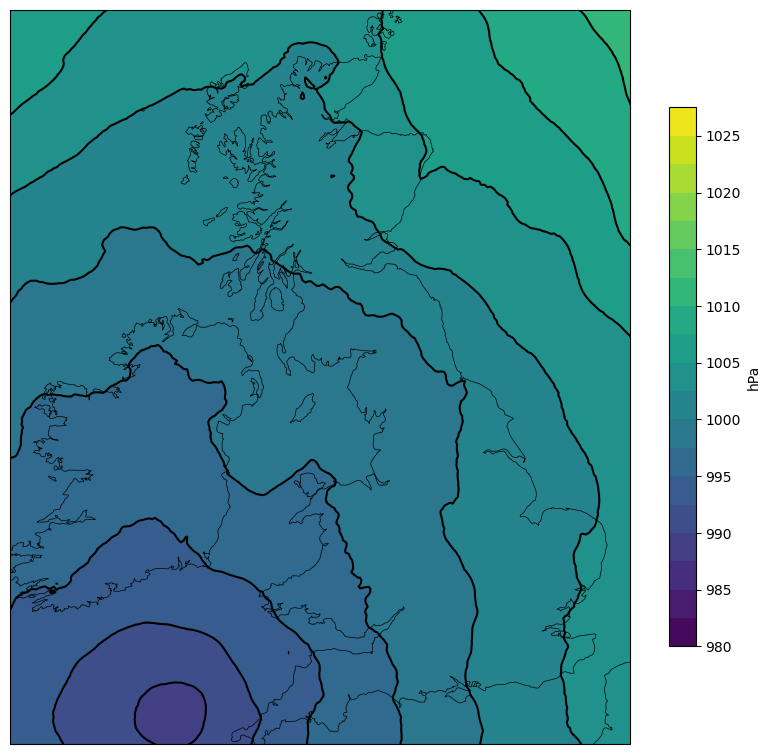

In [30]:
# Create a figure and axes object
fig = plt.figure(figsize=(10,10))


# Set map projection with cart_proj
ax = plt.axes(projection=cart_proj)

# Add coastline features to axes object 
ax.coastlines(linewidth=0.5)

# Add features to the map like contour lines
# Set contour levels 
lvl = np.arange(980, 1030, 2.5) # Non-inclusive of end value (1030)

# Add contour lines
plt.contour(lons,
            lats,
            slp, 
            levels=lvl,
            colors='k',
            transform=crs.PlateCarree())

# Add filled contour lines
plt.contourf(lons,
             lats,
             slp,
             levels=lvl,
             transform=crs.PlateCarree(),
             cmap='viridis')

# Add colorbar
plt.colorbar(ax=ax, shrink=0.7, label='hPa')


# Manually set extent of map projection
ax.set_extent([-10, 2, 50, 59]) # Whole UK

### What's next?

Plot SLP for the other domains (1 and 3):
- Get the right file
- Change map extent
- Change contour levels if required